# Info
Name:  

    KORUS_AOD_fine_coarse_autocorr
    
Purpose:  

    Analyse some of the AOD values from KORUS AQ
    Split up between fine mode and coarse mode AOD
    Subset for level legs only
        - interpolate within the level legs
    Run autocorrelation values for the distance/time travelled 
  
Input:

    None at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - hdf5 python loader
    - 
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - '/aod_ict/all_aod_KORUS_R2_ict.mat'
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-05-18
    Modified: 

# Prepare python environment

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import Sp_parameters as Sp
from load_utils import mat2py_time, toutc, load_ict
import load_utils as lu
import plotting_utils as pu
from path_utils import getpath
import hdf5storage as hs
from datetime import datetime
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import scipy.stats as st

In [2]:
%matplotlib notebook

In [4]:
fp =getpath('KORUS')

Return path named:  KORUS /mnt/c/Users/sleblanc/Research/KORUS-AQ/


# Load files

Load the KORUS 4STAR AOD ict files for better handling

In [5]:
ar = hs.loadmat(fp+'/aod_ict/all_aod_KORUS_R2_ict.mat')

In [6]:
ar.keys()

[u'AOD1040',
 u'AOD0532',
 u'UNCAOD0452',
 u'UNCAOD0550',
 u'AOD1020',
 u'AOD1627',
 u'AOD0606',
 u'UNCAOD0620',
 u'AOD1559',
 u'AOD1064',
 u'AOD0620',
 u'Latitude',
 u'AOD0550',
 u'AOD0452',
 u'fl_alt1',
 u'fl1',
 u'UNCAOD1236',
 u'fl2',
 u'UNCAOD0501',
 u'UNCAOD0606',
 u'qual_flag',
 u'UNCAOD0675',
 u'AOD0520',
 u'UNCAOD1559',
 u'AOD0501',
 u'Longitude',
 u'UNCAOD0380',
 u'fl',
 u'AOD0675',
 u'fl_QA',
 u'AOD1236',
 u'AOD0380',
 u'UNCAOD0865',
 u'Start_UTC',
 u'UNCAOD0781',
 u'days',
 u'UNCAOD0520',
 u'AOD0781',
 u'UNCAOD1064',
 u'fl_alt',
 u'AOD0865',
 u'amass_aer',
 u'UNCAOD1627',
 u'UNCAOD1020',
 u'UNCAOD0532',
 u'UNCAOD1040',
 u'GPS_Alt']

# Run analysis and prepare variables
Do some of the calculations to the data here

In [8]:
fl1 = ar['days']==ar['days'][0]

In [9]:
fl1.shape

(583183,)

## Subset the level legs

In [37]:
def running_std(x,n):
    'Function to do a running standard deviation on array (x) with window size (n)'
    q = x**2
    q = np.convolve(q, np.ones((n, )), mode="valid")
    s = np.convolve(x, np.ones((n, )), mode="valid")
    o = (q-s**2/n)/float(n-1)
    return o 

In [69]:
nbox = 20

In [70]:
std_alt = running_std(ar['GPS_Alt'][fl1],nbox)

In [71]:
std_alt.shape

(30299,)

In [72]:
ar['GPS_Alt'][fl1].shape

(30318,)

In [73]:
f_level = np.where(std_alt<5.0)[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


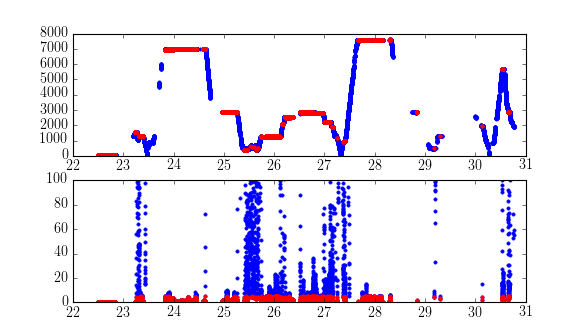

(0, 100)

In [74]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(ar['Start_UTC'][fl1],ar['GPS_Alt'][fl1],'.')
plt.plot(ar['Start_UTC'][fl1][f_level],ar['GPS_Alt'][fl1][f_level],'r.')


ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(ar['Start_UTC'][fl1][:1-nbox],std_alt,'.')
plt.plot(ar['Start_UTC'][fl1][f_level],std_alt[[f_level]],'r.')
plt.ylim(0,100)


## Seperate each of the level legs into distinct segments

In [84]:
def get_segments(index,vals_dict,nsep=150,set_nan=True):
    'Function to seperate continuous segments (within a distance of nsep) based on a prior index'
    disc_flacaod_long = np.where(np.diff(index,1)>nsep)[0]
    
    discontinuity_istart_long =  index[np.append(0,disc_flacaod_long[:-1]+1)]
    discontinuity_iend_long =  index[disc_flacaod_long]
    
    kv = vals_dict.keys()
    d = {k:[] for k in kv}
    for i,start in enumerate(discontinuity_istart_long): # loop through discontinuities 
        for k in kv: # loop through keys
            try:
                d[k].append(vals_dict[k][start:discontinuity_iend_long[i]])
            except:
                d[k].append([np.nan])
    
    for k in kv:
        d[k] = np.array(d[k])
        
    return d

In [80]:
vals = {'utc':ar['Start_UTC'][fl1],'alt':ar['GPS_Alt'][fl1],'lat':ar['Latitude'][fl1],'lon':ar['Longitude'][fl1],
        'aod0500':ar['AOD0501'][fl1],'aod1040':ar['AOD1040'][fl1]}

In [98]:
dvals = get_segments(f_level,vals,nsep=100)

In [99]:
dvals.keys()

['aod1040', 'utc', 'aod0500', 'lon', 'lat', 'alt']

In [103]:
for n in dvals['utc']:
    try:
        print (n[-1]-n[0])*60.0
    except:
        print np.nan

20.55
1.76666666667
4.1
37.6833333333
2.56666666667
18.1
0.0999999999999
1.15
nan
0.0333333333334
0.0166666666667
2.01666666667
2.63333333333
17.1666666667
0.65
9.88333333333
26.5833333333
6.75
1.06666666667
0.0333333333332
1.68333333333
0.4
10.8666666667
1.81666666667
4.28333333333
0.0166666666667
1.06666666667
0.516666666667
0.0
0.0
0.0
1.3


In [111]:
def discrete_matshow(data,cmapname='RdBu'):
    ' plotting function for a discrete colormap'
    cmap = plt.get_cmap(cmapname, np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))
    return cax

In [112]:
plt.figure()
plt.plot(ar['Start_UTC'][fl1],ar['GPS_Alt'][fl1],'.')
plt.plot(ar['Start_UTC'][fl1][f_level],ar['GPS_Alt'][fl1][f_level],'r.')
ax = plt.gca()

ax.set_color_cycle([plt.cm.gist_ncar(k) for k in np.linspace(0, 1, len(dvals['utc'])+1)])

for i,n in enumerate(dvals['utc']):
    plt.plot(n,dvals['alt'][i],'s-',markeredgecolor='None')
    
plt.xlabel('UTC [h from midnight]')
plt.ylabel('Altitude [m]')

#scalarmap = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('gist_ncar'))
#scalarmap.set_array(range(len(dvals['utc'])+1))
#cb = plt.colorbar(scalarmap)
cb = discrete_matshow(range(len(dvals['utc'])+1))
cb.set_label('Level leg number')
#plt.plot(ar['Start_UTC'][fl1][f_level],ar['GPS_Alt'][fl1][f_level],'r.')

<IPython.core.display.Javascript object>

ValueError: need more than 1 value to unpack

# Plotting
Present some fo the early plots here